In [20]:
import streamlit as st
import datetime
from glob import glob
from PIL import Image
import numpy as np
import base64
import io
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from matplotlib.colors import ListedColormap
import re
from pathlib import Path

if '../app' not in sys.path:
    sys.path.append('../app/')

from utils.locate_timings import bin_confusion, confusion2transcript
from utils.identify_theme import send2chatgpt, split_confused_transcripts_by_line


In [21]:
def convert_int(s):
    if s.isdigit():
        return int(s)
    else:
        return s


def alphanum_key(s):
    return [convert_int(c) for c in re.split('([0-9]+)', s)]


def sort_nicely(l):
    l.sort(key=alphanum_key)

In [22]:
random_csv = np.load('../tmp_data/fig4d_random_0416.npy')

In [23]:
all_confused_csvs = glob('../confusion_processed/*.csv')
sort_nicely(all_confused_csvs)

In [24]:
all_1min_norms = []
confused_counts = []
for selected_confused_csv in all_confused_csvs:

    avg_1min = bin_confusion(selected_confused_csv)
    a = np.min(avg_1min)
    avg_1min_norm = avg_1min/a
    all_1min_norms.append(avg_1min_norm)
    
    confused_counts.append(len(np.where(avg_1min_norm > 2)[0]))

all_1min_norms.append(random_csv)
    
    

In [25]:
all_confused_csvs[6]

'../confusion_processed/20190328_confusion.csv'

In [26]:
confused_counts

[7, 0, 30, 32, 1, 0, 9, 3, 0, 5, 0, 0, 6, 0, 4]

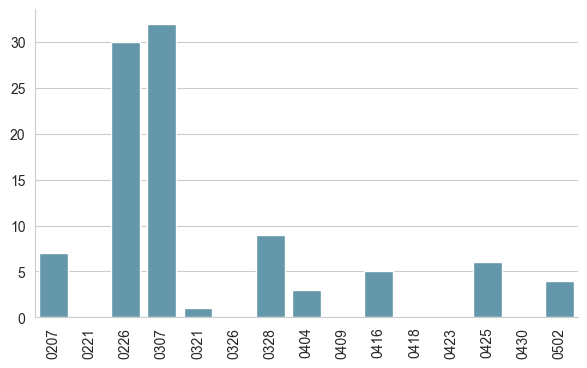

In [27]:
fig, ax = plt.subplots(figsize=(7, 4))
sns.barplot(confused_counts, color='#599CB4', ax=ax)
ax.set_xticks(np.arange(len(all_1min_norms[:-1])), labels=[Path(csv).name.rpartition('_confusion.csv')[0].replace('2019', '') for csv in all_confused_csvs], rotation=90)
ax.spines[['top', 'right']].set_visible(False)
fig.savefig('../figure_panels/fig4_confused_by_class_new.svg', bbox_inches='tight', dpi=300)

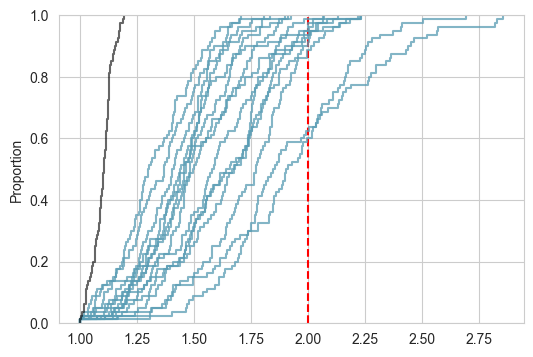

In [28]:
#sns.ecdfplot(all_1min_norms[0])
# sns.ecdfplot(all_1min_norms[1])
# sns.ecdfplot(all_1min_norms[3])
# sns.ecdfplot(all_1min_norms[10])
fig, ax = plt.subplots(figsize=(6, 4))
ax.vlines(2, 0, 1, linestyles='dashed', color='r')
for i, selected in enumerate(all_1min_norms):
    if i == len(all_1min_norms)-1:
        sns.ecdfplot(selected, color='k', ax=ax, alpha=0.6)
    else:
        sns.ecdfplot(selected, color='#599CB4', ax=ax, alpha=0.75)
fig.savefig('../figure_panels/fig4_cdf_new.svg', bbox_inches='tight', dpi=300)
# sns.ecdfplot(random_avg_1min, ax=ax)
# ax.set_xlim([1.75, 2.25])
# ax.set_ylim([0.9, 1.05])

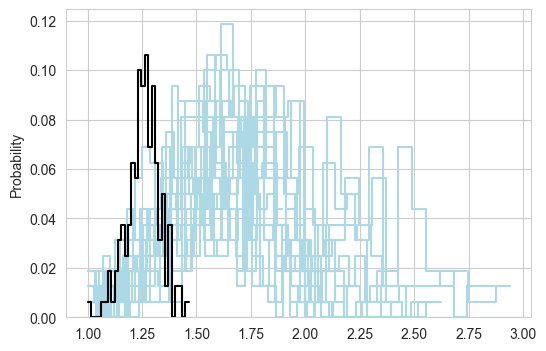

In [114]:
fig, ax = plt.subplots(figsize=(6, 4))
for i, selected in enumerate(all_1min_norms):
    if i == len(all_1min_norms)-1:
        sns.histplot(selected, ax=ax, fill = False, color='k', element='step', stat='probability', bins=30)
    else:
        sns.histplot(selected, ax=ax, fill = False, element='step', color = 'lightblue', stat='probability', bins=30)

In [29]:
p_value_matrix = np.empty((len(all_1min_norms), len(all_1min_norms)))
for i in range(len(all_1min_norms)):
    for j in range(len(all_1min_norms)):
        # if i != j:
        p_value_matrix[i,j] = stats.ks_2samp(all_1min_norms[i], all_1min_norms[j]).pvalue

In [31]:
p_value_matrix

array([[1.00000000e+00, 1.77533698e-06, 1.95382865e-04, 7.31937177e-07,
        4.57420298e-05, 9.55300376e-06, 3.45317969e-02, 1.72979556e-01,
        1.55647298e-08, 8.21938997e-01, 5.49343404e-09, 1.82845572e-11,
        7.83676461e-03, 1.39901038e-03, 8.21938997e-01, 1.45563384e-41],
       [1.77533698e-06, 1.00000000e+00, 1.27459318e-17, 2.08525694e-21,
        3.30696248e-01, 8.21938997e-01, 2.50445866e-14, 4.57420298e-05,
        2.42435114e-01, 5.49343404e-09, 4.53303061e-03, 1.95382865e-04,
        5.37155733e-02, 5.37155733e-02, 7.31937177e-07, 1.01309350e-35],
       [1.95382865e-04, 1.27459318e-17, 1.00000000e+00, 3.30696248e-01,
        2.50445866e-14, 3.00473541e-16, 4.53303061e-03, 2.92774871e-07,
        1.31750325e-20, 3.87147528e-04, 2.45477206e-18, 5.93645219e-24,
        6.20470512e-10, 1.46276457e-12, 1.77533698e-06, 2.76386172e-43],
       [7.31937177e-07, 2.08525694e-21, 3.30696248e-01, 1.00000000e+00,
        2.45477206e-18, 1.27459318e-17, 3.87147528e-04, 6.204

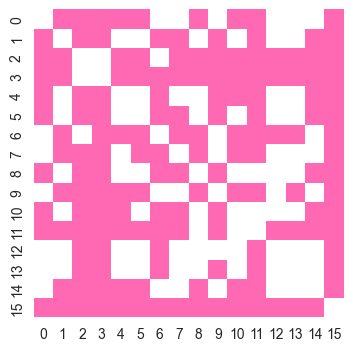

In [30]:
fig, ax = plt.subplots(figsize=(4, 4))
# Create a custom colormap
colors = ["hotpink", "#FFFFFF"]  # Dark blue for p < 0.05, Light blue for p >= 0.05
cmap = ListedColormap(colors)

# Normalize the p_value_matrix for coloring purposes
normalized_p_values = np.where(p_value_matrix < 0.001, 0, 1)

# Plot the heatmap
sns.heatmap(normalized_p_values, cmap=cmap, cbar=False)
plt.show()

model is signigicant by the pvalue by the ks test